W 1 : (3, 1)
B 1 : (1, 1)
Prev Layer: (?, 3)
INFO:tensorflow:Restoring parameters from ./DNN_Model_Initialized-0


AVERAGE COST = 22485.18916562501
BIAS [[0.33279765]]
NEURON: W0[0][0] | VALUE = 0.13046809
NEURON: W0[1][0] | VALUE = 1.1853646
NEURON: W0[2][0] | VALUE = -0.5806416


AVERAGE COST = 19786.935215624988
BIAS [[0.39336535]]
NEURON: W0[0][0] | VALUE = 0.067530766
NEURON: W0[1][0] | VALUE = 1.9424376
NEURON: W0[2][0] | VALUE = -1.3591366


AVERAGE COST = 16986.37548750001
BIAS [[0.4891759]]
NEURON: W0[0][0] | VALUE = 0.07880479
NEURON: W0[1][0] | VALUE = 2.6866052
NEURON: W0[2][0] | VALUE = -2.139061


AVERAGE COST = 14290.351164062498
BIAS [[0.84856623]]
NEURON: W0[0][0] | VALUE = 0.06452049
NEURON: W0[1][0] | VALUE = 3.4054654
NEURON: W0[2][0] | VALUE = -2.919916
Final cost = 248858.97


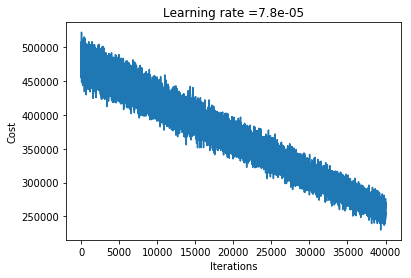

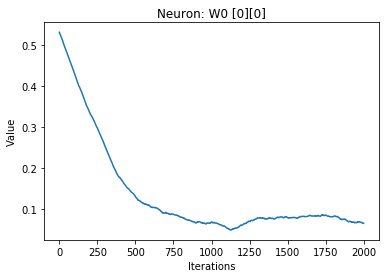

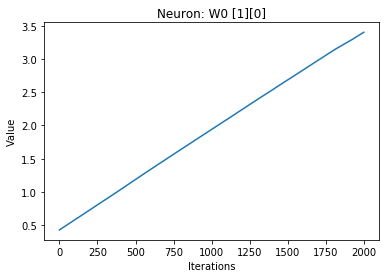

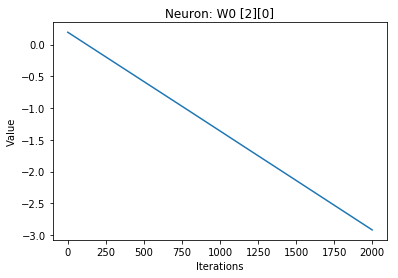

INFO:tensorflow:Restoring parameters from ./DNN_Model_Trained-0
TOTAL ACCURACY = 3.7 %


In [59]:
## OUTPUT (y_size) HAS TO BE = 1 FOR THIS ALGORITHM

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
import random
from inspect import signature


def get_placeholders(x_size,y_size):
    
    X = tf.placeholder(tf.float32, name="X", shape=(None,x_size))
    Y = tf.placeholder(tf.float32, name="Y", shape=(None,y_size))
    
    return X,Y



def create_training_examples(function, x_size, y_size, samples = 1000):
    
    n_vals = x_size
    
    X_train = []
    direct_order = True
    
    #INPUT IS A VECTOR (it will always return size 1)
    #assert len(signature(function).parameters) == x_size, "The number of arguments that the function passed accepts differs from the amount of inputs X!"
    
    mult_array = [1-x/20 for x in range(10)]
    mult_array += [-x for x in mult_array]
    offset_array = [x - samples/2 for x in range(int(samples/10))]
    
    for i in range(x_size):
        
        if direct_order:
            X_train.append([random.choice(mult_array)*R + random.choice(offset_array) for R in range(samples)])
        else:
            X_train.append([random.choice(mult_array)*R + random.choice(offset_array) for R in range(samples,0,-1)])
        
        #We invert the values to give more randomness to the relation between variables for each case
        direct_order = not direct_order
    
    
    X_train = np.reshape(X_train,(n_vals,samples))
    X_train = np.reshape(X_train,(samples,n_vals),1)
    
    Y_train = []
    for i in range(samples):
        Y_train.append(function(X_train[i]))
    Y_train = np.reshape(Y_train,(samples,y_size))
    
    return X_train, Y_train



def create_layer(prev_layer, n_prev, n_post, layer = "", ReLU = True):
    
    W = tf.Variable(tf.random_uniform([n_prev,n_post]), name="W_L"+str(layer), dtype = tf.float32)
    B = tf.Variable(tf.zeros([1,n_post]), name="B_L"+str(layer), dtype = tf.float32)
    print("W",layer,":", np.shape(W))
    print("B",layer,":", np.shape(B))
    print("Prev Layer:", np.shape(prev_layer))
    Z = np.sum((tf.matmul(prev_layer,W),B),axis = 0)
    
    if ReLU:
        A = tf.nn.relu(Z)
    else:
        A = Z
    
    return A,W,B



def create_network(sizes_array):
    
    n = len(sizes_array)
    assert n >= 2, "2 sizes must be given at least: [input_size, (layer_size,) output_size]"
    
    X,Y = get_placeholders(sizes_array[0], sizes_array[n-1])
    
    W_list = []
    B_list = []
    A = X
    for i in range(1, n-1):
        A,W,B = create_layer(A, sizes_array[i-1], sizes_array[i], layer = i, ReLU = True)
        W_list.append(W)
        B_list.append(B)
    
    i = n-1
    A,W,B = create_layer(A, sizes_array[i-1], sizes_array[i], layer = i, ReLU = False)
    W_list.append(W)
    B_list.append(B)
    
    return X, Y, A, W_list, B_list



def print_all_variables(n_w, sizes_array, W_list):
    
    values_dict = {}
    
    n = len(sizes_array)
    assert n >= 2, "2 sizes must be given at least: [input_size, (layer_size,) output_size]"
    
    for elem in range(n_w):
        for i in range(sizes_array[elem]):
            for j in range(sizes_array[elem+1]):
                neuron = "W" + str(elem) + "[" + str(i) + "][" + str(j) + "]"
                values_dict[neuron] = W_list[elem].eval()[i][j]
                print("NEURON:", neuron, "| VALUE =",values_dict[neuron])
    
    return values_dict



def save_all_variables(n_w, sizes_array, W_list, values_dict = {}):
    
    n = len(sizes_array)
    assert n >= 2, "2 sizes must be given at least: [input_size, (layer_size,) output_size]"
    
    for elem in range(n_w):
        for i in range(sizes_array[elem]):
            for j in range(sizes_array[elem+1]):
                neuron = "W" + str(elem) + " [" + str(i) + "][" + str(j) + "]"
                if neuron in values_dict.keys():
                    values_dict[neuron].append(W_list[elem].eval()[i][j])
                else:
                    values_dict[neuron] = [W_list[elem].eval()[i][j]]
    
    return values_dict, neuron




def plot_image(n, obj, training_steps, percentage_shown, y_label = "", title = None):
    
    plt.figure(n)
    aux_i = training_steps - int(training_steps*(percentage_shown/100))
    plt.plot(np.squeeze(obj[aux_i:training_steps]))
    plt.ylabel(y_label)
    plt.xlabel("Iterations")
    if title:
        plt.title(title)
    plt.show()
    
    return



def save_session(parameters,sess,name,identifier):
    
    X,Y,Z,W_list,B_list,sizes_array = parameters
    
    #variables_to_save = []
    #
    #for elem in W_list:
    #    variables_to_save.append(elem)
    #
    #for elem in B_list:
    #    variables_to_save.append(elem)
    #
    #saver = tf.train.Saver(variables_to_save)
    
    saver = tf.train.Saver()
    path = saver.save(sess, './DNN_Model_'+name, global_step=identifier)  ## Last_Model-"identifier"
    
    return path



def restore_session(parameters,sess,path):
    
    X,Y,Z,W_list,B_list,sizes_array = parameters
    
    #variables_to_save = []
    #
    #for elem in W_list:
    #    variables_to_save.append(elem)
    #
    #for elem in B_list:
    #    variables_to_save.append(elem)
    #
    #saver = tf.train.Saver(variables_to_save)
    
    saver = tf.train.Saver()
    path = saver.restore(sess, path)
    
    return path



def create_model(x_size, y_size, middle_layers = None):
    
    assert y_size == 1, "Y SIZE has to be equal 1 for this example"
    
    sizes_array = [x_size, y_size]
    if middle_layers:
        for layer in middle_layers:
            n = len(sizes_array)
            sizes_array.insert(n-1, layer)
    
    n_w = len(sizes_array)-1
    
    
    with tf.Session() as sess:
        np.random.seed(1)
    
        X,Y,Z,W_list,B_list = create_network(sizes_array)

        cross_entropy = tf.reduce_mean(tf.reduce_sum(abs(Y-Z)))
        train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)

        init = tf.global_variables_initializer()
        sess.run(init)
        
        saved_session = save_session(parameters,sess,"Initialized",0)
        
        return [X,Y,Z,W_list,B_list,sizes_array],[cross_entropy,train_step],saved_session
    
    return None



def train_model(parameters, saved_session, cost_definition, X_train, Y_train, training_steps = 40000, learning_rate = 0.000078, batch_size = 20, plot_cost = True, print_variables = [20,None]):
    
    X,Y,Z,W_list,B_list,sizes_array = parameters
    n_w = len(sizes_array)-1
    cross_entropy,train_step = cost_definition
    
    
    with tf.Session() as sess:
        #init = tf.global_variables_initializer()
        #sess.run(init)
        
        restore_session(parameters,sess,saved_session)
        
        average_cost = 0
        cost_list = []
        
        if print_variables != None:
            assert len(print_variables) == 2, "2 PARAMETERS MUST BE PASSED ON 'print_variables': 1st - # of training steps to take a record | 2nd # of records to plot values"
            n = print_variables[0]
            
            if print_variables[1]:
                n_2 = print_variables[1]
            else:
                n_2 = int(training_steps/n)
            
            if n < 1:
                n = 1
            if n_2 < 1:
                n_2 = 1
            
            values_dict = {}
        
        for i in range(training_steps):
            i_batch = random.sample(range(np.shape(X_train)[0]),batch_size)
            a = sess.run([train_step,cross_entropy], feed_dict={X: X_train[i_batch,:], Y: Y_train[i_batch]})
            
            if plot_cost:
                cost_list.append(a[1])
            
            if print_variables != None:
                if i%(n*n_2) == 0 and i != 0:
                    average_cost += a[1]/(n*n_2)
                    print("\n")
                    print("AVERAGE COST =",average_cost)
                    average_cost = 0
                    print("BIAS",B_list[0].eval())
                    #print("BIAS",B_list[1].eval())
                    
                    print_all_variables(n_w, sizes_array, W_list)

                if i%n == 0 and i != 0:
                    average_cost += a[1]/(n*n_2)
                    values_dict,_ = save_all_variables(n_w, sizes_array, W_list, values_dict)
        
        print("Final cost =",a[1])

        fig = 0
        if plot_cost:
            plot_image(fig, cost_list, training_steps, 100, y_label = "Cost", title = "Learning rate =" + str(learning_rate))
            fig += 1

        if print_variables != None:
            for neuron in values_dict.keys():
                plot_image(fig, values_dict[neuron], training_steps, 100, y_label = "Value", title = "Neuron: " + neuron)
                fig += 1
        
        saved_session = save_session(parameters,sess,"Trained",0)
        
        return [X,Y,Z,W_list,B_list,sizes_array],saved_session
    
    return None



def test_model(parameters, saved_session, X_test, Y_test, test_steps = 4000):
    
    X,Y,Z,W_list,B_list,sizes_array = parameters
    
    with tf.Session() as sess:
        
        restore_session(parameters,sess,saved_session)
        
        #correct_prediction = tf.equal(tf.argmax(Z,1),tf.argmax(Y,1))
        a_val = tf.abs((Y-Z)/tf.maximum(Z,Y))
        accuracy = tf.reduce_mean(tf.cast(a_val,tf.float32), name = 'Accuracy')
        
        total_accuracy = 0
        for i in range(test_steps):
            a = sess.run([accuracy], feed_dict={X:X_test, Y:Y_test})
            total_accuracy += (1/(1+2*a[0]))*100/test_steps

        total_accuracy = int(total_accuracy*10)/10
        print("TOTAL ACCURACY =",total_accuracy,"%")
        
        return total_accuracy
    
    return None
    




if __name__ == "__main__":
    
    ## INITIALIZATION
    x_size = 3
    y_size = 1
    middle_layers = None #[2] #None (if only 1 layer)
    
    ## TRAINING
    training_steps = 40001
    learning_rate = 0.000078
    batch_size = 256
    print_variables = [20,500]
    
    ## TESTING
    test_steps = 2000
    
    #CREATE TRAINING SAMPLES
    function = lambda INPUT: 2*INPUT[0] + 5*INPUT[1] - 7*INPUT[2]
    samples = 500
    assert samples >= batch_size, "# of SAMPLES (training batch) has to be greater or equal than the BATCH SIZE"
    X_train, Y_train = create_training_examples(function, x_size, y_size, samples)
    
    #CREATE TESTING SAMPLES
    samples = 200
    X_test, Y_test = create_training_examples(function, x_size, y_size, samples)
    
    
    
    ## CALLING INITIALIZATION
    parameters,cost_definition,saved_session = create_model(x_size, y_size, middle_layers = None)
    
    ## TRAIN MODEL
    parameters,saved_session = train_model(parameters, saved_session, cost_definition, X_train, Y_train, training_steps, learning_rate, batch_size, print_variables = print_variables)
    
    ## TEST MODEL
    accuracy = test_model(parameters, saved_session, X_test, Y_test, test_steps = 4000)
    
    
    
    

INFO:tensorflow:Restoring parameters from ./DNN_Model_Trained-0


AVERAGE COST = 11612.0247203125
BIAS [[1.464859]]
NEURON: W0[0][0] | VALUE = 0.046804752
NEURON: W0[1][0] | VALUE = 4.039608
NEURON: W0[2][0] | VALUE = -3.7005866


AVERAGE COST = 9118.12893906251
BIAS [[2.131115]]
NEURON: W0[0][0] | VALUE = 0.3935668
NEURON: W0[1][0] | VALUE = 4.3834963
NEURON: W0[2][0] | VALUE = -4.4796143


AVERAGE COST = 6666.557278906246
BIAS [[2.8050532]]
NEURON: W0[0][0] | VALUE = 0.8591644
NEURON: W0[1][0] | VALUE = 4.6012387
NEURON: W0[2][0] | VALUE = -5.258297


AVERAGE COST = 4240.086800000003
BIAS [[3.4787328]]
NEURON: W0[0][0] | VALUE = 1.3679849
NEURON: W0[1][0] | VALUE = 4.7844925
NEURON: W0[2][0] | VALUE = -6.03727


AVERAGE COST = 1788.9776927734374
BIAS [[4.1135736]]
NEURON: W0[0][0] | VALUE = 1.8823074
NEURON: W0[1][0] | VALUE = 4.967508
NEURON: W0[2][0] | VALUE = -6.816172
Final cost = 11709.34


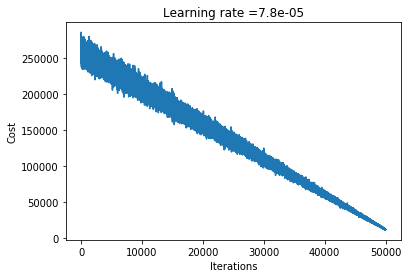

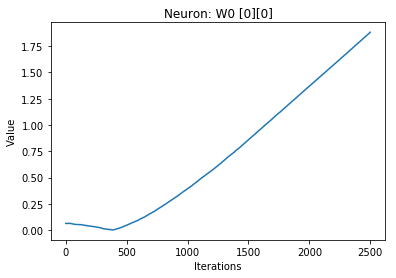

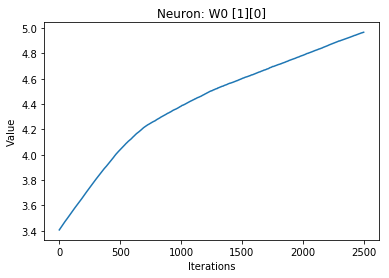

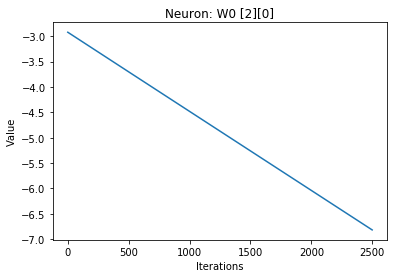

INFO:tensorflow:Restoring parameters from ./DNN_Model_Trained-0
TOTAL ACCURACY = 92.1 %


In [60]:
# We end with 3.7% accuracy after 50001 steps

## EXTRA TRAINING
training_steps = 50001
parameters,saved_session = train_model(parameters, saved_session, cost_definition, X_train, Y_train, training_steps, learning_rate, batch_size, print_variables = print_variables)


## TESTING
accuracy = test_model(parameters, saved_session, X_test, Y_test, test_steps = 4000)
  

In [61]:
# After another 50001 steps, we reach 92.1% ACCURACY
# Values are almost reaching the KNOWN REAL VALUES from the function given: W0[0] = 2 | W0[1] = 5 | W0[0] = -7
